In [1]:
import pandas as pd
import numpy as np 
import re
import string
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    

In [3]:
data = pd.read_csv('../data/data_F.csv', sep=';') # lecture data set 
department = np.copy(data['zip_code'].values)

In [4]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if not embeded_words[word].endswith('_i'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

def compute_moyenne(sentence_embedding):
    result = []
    #print(len(sentence_embedding[0]))
    for index in range(len(sentence_embedding[0])): # taille 700
        result.append(np.sum(sentence_embedding[:,index])/len(sentence_embedding))
    return result

In [65]:
scores = []
for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        # score de taille 700
        scores.append(compute_moyenne(answer))#,compute_variance(answer, eval_type='var'),compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan]*700)
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns = ['score_'+str(i) for i in range(700)]) 
argumentation_scores = pd.concat([data['annotation'],scores_df], axis=1) 
argumentation_scores.head(2)

100%|██████████| 2445/2445 [00:39<00:00, 62.38it/s]


,annotation,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,...,score_690,score_691,score_692,score_693,score_694,score_695,score_696,score_697,score_698,score_699
0,1.0,0.002184,-0.015336,-0.015614,0.004679,0.032181,0.061739,-0.052617,0.034983,-0.054036,...,0.029986,0.039820,-0.003342,0.030171,-0.050199,0.039690,-0.009338,-0.014119,0.052214,-0.037971
1,1.0,0.063287,-0.016981,0.022253,-0.004149,0.041670,0.072220,-0.055472,0.000335,-0.045204,...,0.010781,0.019873,-0.005545,-0.014305,-0.030772,0.017193,0.039085,0.000324,0.008392,-0.034817


In [66]:
argumentation_scores = argumentation_scores.dropna()
print(argumentation_scores.shape)
X = argumentation_scores.drop('annotation',axis=1)
Y = argumentation_scores['annotation']
X.head(2)
Y.head(2)

(2445, 701)


0    1.0
1    1.0
Name: annotation, dtype: float64

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
freq_1 = y_train.mean()

### Unbalanced weights

In [11]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9)
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1223  206]
 [ 112  415]]
             precision    recall  f1-score   support

        0.0       0.92      0.86      0.88      1429
        1.0       0.67      0.79      0.72       527

avg / total       0.85      0.84      0.84      1956

1956 621.0
0.7229965156794425
---------------Scores on test---------------
[[288  64]
 [ 85  52]]
             precision    recall  f1-score   support

        0.0       0.77      0.82      0.79       352
        1.0       0.45      0.38      0.41       137

avg / total       0.68      0.70      0.69       489

489 137.0
0.4110671936758893


### Default Balanced weights

In [12]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=5, class_weight='balanced')
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1003   74]
 [ 332  547]]
             precision    recall  f1-score   support

        0.0       0.75      0.93      0.83      1077
        1.0       0.88      0.62      0.73       879

avg / total       0.81      0.79      0.79      1956

1956 621.0
0.7293333333333333
---------------Scores on test---------------
[[222 130]
 [ 41  96]]
             precision    recall  f1-score   support

        0.0       0.84      0.63      0.72       352
        1.0       0.42      0.70      0.53       137

avg / total       0.73      0.65      0.67       489

489 137.0
0.5289256198347108


### Custom Balanced weights

In [13]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9, class_weight= {0:freq_1, 1:1-freq_1})
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[989  80]
 [346 541]]
             precision    recall  f1-score   support

        0.0       0.74      0.93      0.82      1069
        1.0       0.87      0.61      0.72       887

avg / total       0.80      0.78      0.78      1956

1956 621.0
0.7175066312997348
---------------Scores on test---------------
[[218 134]
 [ 43  94]]
             precision    recall  f1-score   support

        0.0       0.84      0.62      0.71       352
        1.0       0.41      0.69      0.52       137

avg / total       0.72      0.64      0.66       489

489 137.0
0.5150684931506849


### Dimensionality reduction 

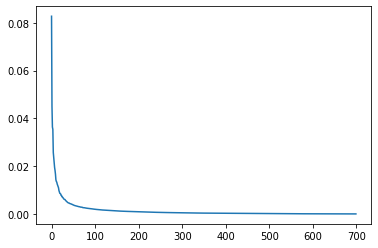

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=700)
pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)


In [15]:
pca = PCA(n_components=313)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

In [16]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='linear', C=6.03e-01, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[866 100]
 [469 521]]
             precision    recall  f1-score   support

        0.0       0.65      0.90      0.75       966
        1.0       0.84      0.53      0.65       990

avg / total       0.74      0.71      0.70      1956

1956 621.0
0.6468032278088144
---------------Scores on test---------------
[[217 135]
 [ 26 111]]
             precision    recall  f1-score   support

        0.0       0.89      0.62      0.73       352
        1.0       0.45      0.81      0.58       137

avg / total       0.77      0.67      0.69       489

489 137.0
0.5796344647519583


### Cross Validation 

In [17]:
from tqdm import trange
n_split = 1
n_val = 800
cv_parameters = {'log_10_C': [-1, 2],
                 'n_comp':[10, 400] }
scores = []
log_10_cs = []
n_comps = []

progress_bar = trange(n_val, desc='Bar desc', leave=True)
for n in progress_bar:
    log_10_c = np.random.random() * (cv_parameters['log_10_C'][1] - cv_parameters['log_10_C'][0]) + cv_parameters['log_10_C'][0]
    n_comp = int(np.random.random() * (cv_parameters['n_comp'][1] - cv_parameters['n_comp'][0]) + cv_parameters['n_comp'][0])
    n_comps.append(n_comp)
    log_10_cs.append(log_10_c)
    f1_mean = []
    for split in range(n_split): 
        
        X_cv_train, X_val, y_cv_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=split)
        
        pca = PCA(n_components=n_comp)
        
        pca.fit_transform(X_train)
        X_train_pca = pca.transform(X_cv_train)
        X_test_pca = pca.transform(X_val)
        
        svclassifier = SVC(kernel='linear', C=10**log_10_c, class_weight= 'balanced')
        svclassifier.fit(X_train_pca, y_cv_train)
        
        y_pred = svclassifier.predict(X_test_pca)
        f1_mean.append(f1_score(y_pred,y_val))
    scores.append(np.mean(f1_mean))
    i_max = scores.index(max(scores))
    progress_bar.set_description('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))
    progress_bar.refresh()
    
        
i_max = scores.index(max(scores))
print('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))


best f1 : 5.98e-01 |  for C = 8.71e-01 with 274 components:  12%|█▏        | 95/800 [20:08<2:38:11, 13.46s/it]

KeyboardInterrupt: 

### PCA on all dataset

In [5]:
data_unnanotated = pd.read_csv('../data/dataset_1.csv') # lecture data set 
print(data_unnanotated)

       Unnamed: 0  zip_code  \
0               1   57000.0   
1               5   95330.0   
2               6   84750.0   
3              11   33820.0   
4              15    8500.0   
5              20   28600.0   
6              21   11390.0   
7              29   49000.0   
8              30   29280.0   
9              31   33130.0   
10             33   63730.0   
11             36   59000.0   
12             38       0.0   
13             40   34000.0   
14             42   60153.0   
15             46   92400.0   
16             48   92500.0   
17             50   17138.0   
18             53    1500.0   
19             58   13390.0   
20             62   73000.0   
21             63   41290.0   
22             64   82000.0   
23             68   78130.0   
24             74   78150.0   
25             76   45100.0   
26             77   41250.0   
27             80   83140.0   
28             81   67000.0   
29             83   31200.0   
...           ...       ...   
66527   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


113.35138773918152
---------------Scores on train---------------
[[807 112]
 [528 509]]
             precision    recall  f1-score   support

        0.0       0.60      0.88      0.72       919
        1.0       0.82      0.49      0.61      1037

avg / total       0.72      0.67      0.66      1956

1956 621.0
0.6139927623642943
---------------Scores on test---------------
[[213 139]
 [ 21 116]]
             precision    recall  f1-score   support

        0.0       0.91      0.61      0.73       352
        1.0       0.45      0.85      0.59       137

avg / total       0.78      0.67      0.69       489

489 137.0
0.5918367346938775


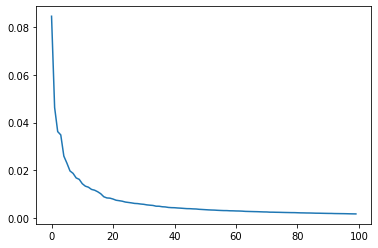

In [73]:
import time 
from sklearn.decomposition import PCA
from sklearn.svm import SVC

start = time.time()
unnanotated_embeded_data = data_unnanotated.head(10000)['solution'].map(lambda x : np.mean(embed_answer(x).reshape(-1,700),axis=0))
print(time.time()-start)
x = pd.DataFrame(np.asarray(unnanotated_embeded_data.tolist()).astype(np.float64))
x = x.dropna()

pca = PCA(n_components=100)
pca.fit_transform(x)
plt.plot(pca.explained_variance_ratio_)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


svclassifier = SVC(kernel='linear', C=6.03e-01, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

In [93]:
x['pred'] = svclassifier.predict(pca.transform(x.drop('Department',axis=1)))

In [89]:
x['Department'] = data_unnanotated['zip_code'] // 1000

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,0.007224,-0.018928,-0.015692,0.004884,0.034927,0.064126,-0.054061,0.037434,-0.061646,-0.003507,...,0.029842,0.034282,-0.007757,0.030578,-0.046678,0.035420,-0.004989,-0.010232,0.047805,-0.037694
1,0.061707,-0.019779,0.023700,-0.002620,0.036888,0.067803,-0.054617,-0.002381,-0.041077,-0.057780,...,0.011981,0.018971,-0.004546,-0.016217,-0.026465,0.018937,0.034689,0.003283,0.011223,-0.032094
2,0.062479,-0.016062,0.022250,-0.007306,0.061340,0.070155,-0.063448,0.031735,-0.137925,-0.039277,...,0.010198,0.011956,-0.021904,0.014571,-0.027251,0.023213,0.028321,0.043685,-0.010480,-0.013711
3,0.136225,-0.093007,0.003619,0.026869,0.057067,0.102000,-0.123075,0.012990,-0.082796,0.005155,...,0.088216,-0.011502,-0.079337,0.027293,-0.071953,-0.053504,-0.034882,0.111229,0.024426,-0.039842
4,0.037710,-0.054166,0.011200,-0.036107,-0.003270,0.021288,-0.063551,-0.018885,-0.050624,-0.046092,...,0.010539,0.062242,-0.013465,0.043487,-0.030116,0.037946,-0.004833,-0.031555,-0.021488,-0.015373
5,0.044008,-0.030442,0.040979,0.014855,0.043957,0.119844,-0.064233,0.007401,-0.016551,-0.029035,...,0.035812,0.033511,-0.007084,-0.038157,-0.044625,-0.009350,0.006107,0.029026,0.036696,-0.051071
6,0.053828,-0.050106,0.017752,-0.033939,0.029088,0.034120,-0.135843,0.010875,-0.090924,-0.006585,...,0.109167,0.017601,-0.046829,0.026287,-0.031210,0.008301,0.007965,0.068244,0.058199,0.045689
7,0.013942,-0.088146,0.031556,0.075670,0.086891,0.087568,-0.108111,-0.010792,-0.053309,-0.015862,...,0.036565,-0.030476,-0.027754,-0.033668,-0.089159,-0.007970,-0.080292,0.054372,0.054673,-0.017321
8,0.059265,-0.120530,0.025512,-0.027247,0.052245,0.124286,-0.072793,0.002891,-0.032137,0.001775,...,-0.038950,0.069045,-0.016575,0.009035,-0.032397,0.004815,-0.024131,0.004321,0.022271,-0.049432
9,0.103657,-0.133469,0.027737,-0.045838,0.061361,0.102410,-0.082837,-0.070167,-0.066852,0.062904,...,0.014400,-0.054573,-0.067236,-0.089781,0.017827,-0.053541,0.044077,0.141332,-0.035521,-0.005752


In [94]:
x.head(5)

,0,1,2,3,4,5,6,7,8,9,...,692,693,694,695,696,697,698,699,Department,pred
0,0.007224,-0.018928,-0.015692,0.004884,0.034927,0.064126,-0.054061,0.037434,-0.061646,-0.003507,...,-0.007757,0.030578,-0.046678,0.035420,-0.004989,-0.010232,0.047805,-0.037694,57.0,1.0
1,0.061707,-0.019779,0.023700,-0.002620,0.036888,0.067803,-0.054617,-0.002381,-0.041077,-0.057780,...,-0.004546,-0.016217,-0.026465,0.018937,0.034689,0.003283,0.011223,-0.032094,95.0,1.0
2,0.062479,-0.016062,0.022250,-0.007306,0.061340,0.070155,-0.063448,0.031735,-0.137925,-0.039277,...,-0.021904,0.014571,-0.027251,0.023213,0.028321,0.043685,-0.010480,-0.013711,84.0,1.0
3,0.136225,-0.093007,0.003619,0.026869,0.057067,0.102000,-0.123075,0.012990,-0.082796,0.005155,...,-0.079337,0.027293,-0.071953,-0.053504,-0.034882,0.111229,0.024426,-0.039842,33.0,0.0
4,0.037710,-0.054166,0.011200,-0.036107,-0.003270,0.021288,-0.063551,-0.018885,-0.050624,-0.046092,...,-0.013465,0.043487,-0.030116,0.037946,-0.004833,-0.031555,-0.021488,-0.015373,8.0,1.0


In [97]:
unique_dpt = np.unique(x['Department'], return_counts=True)[0]
mapping = {'pred':{}}

for eval_type in mapping.keys():
    for dpt in unique_dpt:
        values = x[x['Department']==dpt][eval_type].dropna().values
        try:
            percentile = np.percentile(abs(values),95)
            valid_values = values[abs(values)<=percentile]

            M = np.mean(valid_values)
            V = np.var(valid_values)
        except:
            M, V = np.nan, np.nan

        mapping[eval_type][dpt] = [M,V]
    
    
    # May need to add this to the dataframe... Then, uncomment the code below
    #try:
    #    final_data = final_data.drop(eval_type + '_mean_wrt_dpt', axis=1)
    #except:
    #    pass
    #means = []
    #for index in final_data.index:
    #    means.append(mapping[eval_type][final_data['Department'][index]][0])

    #means = pd.DataFrame(means, index=final_data.index, columns=[eval_type + '_mean_wrt_dpt'])
    #final_data = pd.concat([final_data, means], axis=1)

In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.options.mode.chained_assignment = None  # default='warn'

def plot_cartography(Colors, eval_type, figsize=(10, 6)):
    # set the filepath and load in a shapefile
    fp = '../data/departements-20180101-shp/departements-20180101.shp'
    map_df = gpd.read_file(fp)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
    merged = map_df.set_index('code_insee').join(Colors.set_index('code_insee'))
    merged['colors']['2A'] = merged['colors']['2B'] = Colors['colors'][20]
    merged['colors']['69D'] = merged['colors']['69M'] = Colors['colors'][69]
    for idx in merged.index:
        if idx not in Colors['code_insee'].values and idx!='2A' and idx!='2B' and idx!='69D' and idx!='69M':
            merged = merged.drop(index=idx)
    merged.head()

    # set a variable that will call whatever column we want to visualise on the map
    variable = 'colors'
    # set the range for the choropleth
    vmin, vmax = np.min(merged[variable].values)-1e-5, np.max(merged[variable].values)
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=figsize)

    # create map
    merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

    ax.axis('off')

    ax.set_title("French Departments, colors correpond to the mean of the argumentation scores : " + eval_type,
                 fontdict={'fontsize': '10', 'fontweight' : '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

In [98]:
dpts = [k for k in range(1,96)]
for eval_type in ['pred']:
    Colors = []
    for dpt in dpts:
        Colors.append(mapping[eval_type][dpt][0]) # Because in the geopandas the departments go from 0 to 94

    Colors = pd.DataFrame(Colors, index=dpts, columns=['colors'])
    Colors = pd.concat([Colors, pd.DataFrame(['0'+str(k) for k in range(1,10)] + [str(k) for k in range(10,96)],
                                             index=dpts, columns=['code_insee'])], axis=1)

    plot_cartography(Colors, eval_type, figsize=(10,6))
    plt.savefig('../../{}.png'.format(eval_type))

DriverError: ../data/departements-20180101-shp/departements-20180101.shp: No such file or directory

### logistic regression

In [18]:
pca = PCA(n_components=500)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 


from sklearn.linear_model import LogisticRegression 
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr', C=100.0,
                        class_weight='balanced')

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))



---------------Scores on train---------------
[[1073   88]
 [ 262  533]]
             precision    recall  f1-score   support

        0.0       0.80      0.92      0.86      1161
        1.0       0.86      0.67      0.75       795

avg / total       0.83      0.82      0.82      1956

1956 621.0
0.7528248587570622
---------------Scores on test---------------
[[241 111]
 [ 56  81]]
             precision    recall  f1-score   support

        0.0       0.81      0.68      0.74       352
        1.0       0.42      0.59      0.49       137

avg / total       0.70      0.66      0.67       489

489 137.0
0.49240121580547114


In [19]:
pca = PCA(n_components=30)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 


from sklearn.ensemble import RandomForestClassifier 


clf = RandomForestClassifier(n_estimators=190, max_depth=6, class_weight='balanced')
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


---------------Scores on train---------------
[[1058   63]
 [ 277  558]]
             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86      1121
        1.0       0.90      0.67      0.77       835

avg / total       0.84      0.83      0.82      1956

1956 621.0
0.7664835164835165
---------------Scores on test---------------
[[256  96]
 [ 45  92]]
             precision    recall  f1-score   support

        0.0       0.85      0.73      0.78       352
        1.0       0.49      0.67      0.57       137

avg / total       0.75      0.71      0.72       489

489 137.0
0.5661538461538461


In [20]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=clf)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1282    0]
 [  53  621]]
             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98      1282
        1.0       1.00      0.92      0.96       674

avg / total       0.97      0.97      0.97      1956

1956 621.0
0.959073359073359
---------------Scores on test---------------
[[293  59]
 [ 62  75]]
             precision    recall  f1-score   support

        0.0       0.83      0.83      0.83       352
        1.0       0.56      0.55      0.55       137

avg / total       0.75      0.75      0.75       489

489 137.0
0.5535055350553505
